## 1. Imports va Cau hinh

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import Xception

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [2]:
# Cau hinh
DATASET_DIR = 'data/brisc2025'
TRAIN_DIR = os.path.join(DATASET_DIR, 'classification_task', 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'classification_task', 'test')
# Model paths - pretrained models
XCEPTION_MODEL_PATH = 'model/model1_nguyenvantanphat.keras'
# Hyperparameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
NUM_CLASSES = len(CLASSES)

## 2. EDA - Exploratory Data Analysis

In [7]:

from collections import Counter

def check_image_details(df, n_samples=1000):
    # Lay mau ngau nhien
    samples = df.sample(min(len(df), n_samples), random_state=42)
    sizes = []
    contrasts = []
    print(f"Dang quet {len(samples)} anh...")
    
    for _, row in samples.iterrows():
        img = cv2.imread(row['image_path'])
        if img is None: continue
        
        h, w = img.shape[:2]
        sizes.append(f"{w}x{h}") # Luu dang chuoi "Rong x Cao"
        
        # Tinh tuong phan
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        contrasts.append(gray.std())
    
    # --- 1. LIET KE KICH THUOC ---
    print("CAC KICH THUOC ANH TIM THAY (Width x Height)")
    # Dem so luong tung loai kich thuoc
    size_counts = Counter(sizes)
    # In ra cac kich thuoc pho bien nhat
    for size, count in size_counts.most_common():
        print(f"  {size:<10} : {count} anh")
    # --- 2. THONG SO TUONG PHAN ---
    print("-" * 40)
    print("DO TUONG PHAN (CONTRAST)")
    print("-" * 40)
    avg_c = np.mean(contrasts)
    min_c = np.min(contrasts)
    max_c = np.max(contrasts)
    print(f"  Trung binh : {avg_c:.2f}")
    print(f"  Min        : {min_c:.2f}")
    print(f"  Max        : {max_c:.2f}")
# Chay ham
check_image_details(train_df)

Dang quet 1000 anh...
CAC KICH THUOC ANH TIM THAY (Width x Height)
  512x512    : 833 anh
  369x369    : 64 anh
  216x369    : 51 anh
  187x369    : 9 anh
  202x369    : 5 anh
  256x256    : 4 anh
  225x225    : 3 anh
  442x442    : 2 anh
  236x236    : 2 anh
  233x243    : 1 anh
  200x235    : 1 anh
  238x212    : 1 anh
  236x269    : 1 anh
  591x650    : 1 anh
  212x237    : 1 anh
  229x223    : 1 anh
  200x223    : 1 anh
  224x219    : 1 anh
  205x251    : 1 anh
  210x240    : 1 anh
  230x235    : 1 anh
  306x306    : 1 anh
  264x336    : 1 anh
  491x624    : 1 anh
  253x239    : 1 anh
  1280x1280  : 1 anh
  450x446    : 1 anh
  236x226    : 1 anh
  306x365    : 1 anh
  257x307    : 1 anh
  210x369    : 1 anh
  236x280    : 1 anh
  685x681    : 1 anh
  236x221    : 1 anh
  273x326    : 1 anh
  645x439    : 1 anh
----------------------------------------
DO TUONG PHAN (CONTRAST)
----------------------------------------
  Trung binh : 43.81
  Min        : 24.25
  Max        : 89.24


Ảnh có kích thước khác nhau và độ tương phản thấp

In [3]:
# 2.1 Thong ke so luong anh moi class
def count_images(directory):
    counts = {}
    for cls in CLASSES:
        cls_dir = os.path.join(directory, cls)
        if os.path.exists(cls_dir):
            counts[cls] = len([f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        else:
            counts[cls] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print("So luong anh Training:")
for cls, count in train_counts.items():
    print(f"  {cls}: {count}")
print(f"  Tong: {sum(train_counts.values())}")

print("\nSo luong anh Testing:")
for cls, count in test_counts.items():
    print(f"  {cls}: {count}")
print(f"  Tong: {sum(test_counts.values())}")

So luong anh Training:
  glioma: 1147
  meningioma: 1329
  no_tumor: 1067
  pituitary: 1457
  Tong: 5000

So luong anh Testing:
  glioma: 254
  meningioma: 306
  no_tumor: 140
  pituitary: 300
  Tong: 1000


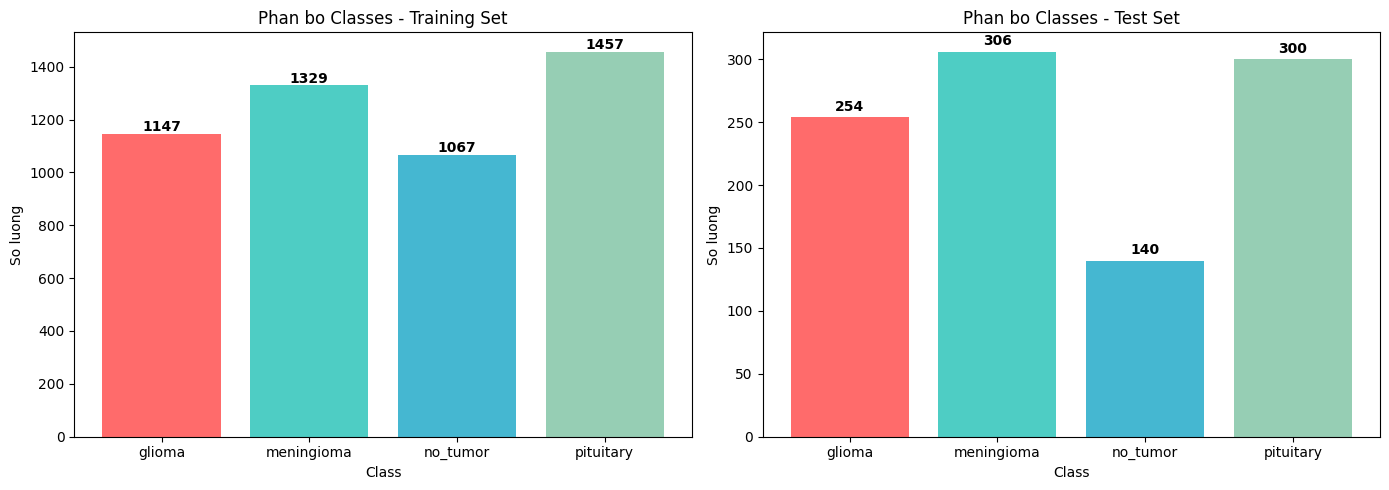

In [4]:
# 2.2 Bieu do phan bo classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
axes[0].bar(train_counts.keys(), train_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0].set_title('Phan bo Classes - Training Set')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('So luong')
for i, (cls, v) in enumerate(train_counts.items()):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Test distribution
axes[1].bar(test_counts.keys(), test_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1].set_title('Phan bo Classes - Test Set')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('So luong')
for i, (cls, v) in enumerate(test_counts.items()):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Lớp No Tumor (Không u) có số lượng mẫu ít nhất ở cả tập Train (1067) và đặc biệt là tập Test (140, chỉ bằng ~1/2 so với Meningioma/Pituitary).

Tỷ lệ phân bố giữa tập Train và tập Test là tương đồng nhau (Pituitary nhiều nhất -> No Tumor ít nhất). 

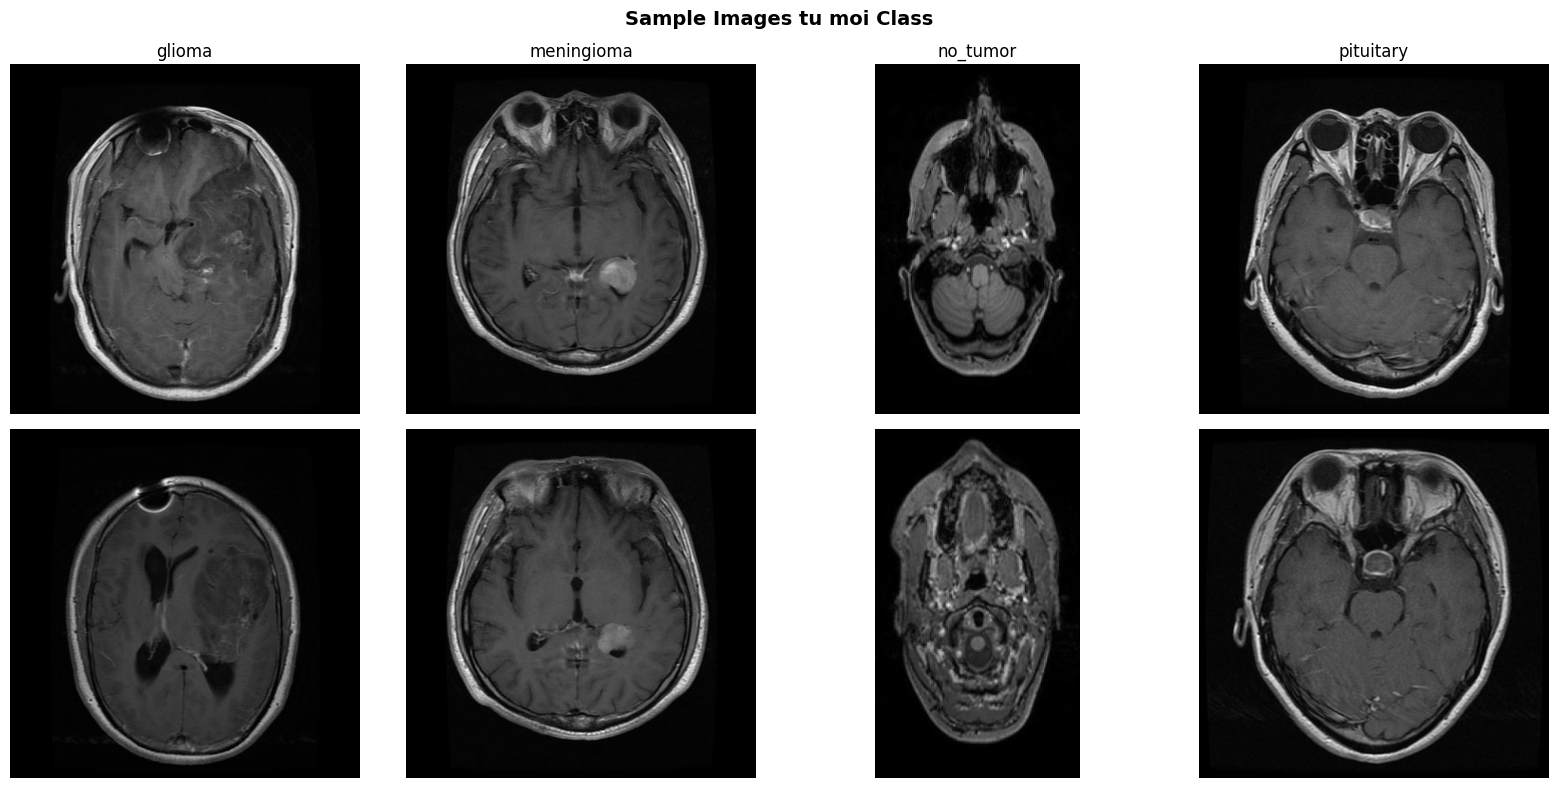

In [5]:
# 2.3 Hien thi sample images tu moi class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    if os.path.exists(cls_dir):
        images = os.listdir(cls_dir)
        if images:
            img_path = os.path.join(cls_dir, images[0])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"{cls}")
            axes[0, i].axis('off')
            
            if len(images) > 1:
                img_path = os.path.join(cls_dir, images[1])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[1, i].imshow(img)
            axes[1, i].axis('off')

plt.suptitle('Sample Images tu moi Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Data Preparation

In [6]:
# 3.1 Preprocessing functions
def resize_with_padding(image, target_size=(299, 299)):
    """Resize anh ma KHONG bi meo (them vien den)"""
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(image, (new_w, new_h))
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def preprocess_image(image):
    """CLAHE enhancement + normalize to [-1, 1]"""
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    
    return enhanced.astype(np.float32) / 127.5 - 1.0

In [7]:
# 3.2 Custom Data Generator cho Classification (NO augmentation)
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, img_size=(299, 299), 
                 shuffle=False, class_names=None):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.class_names = class_names or sorted(dataframe['label'].unique())
        self.n_classes = len(self.class_names)
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[batch_indexes]
        X = np.zeros((len(batch_data), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), self.n_classes), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            img = cv2.imread(row['filepath'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = resize_with_padding(img, self.img_size)
            X[i] = preprocess_image(img)
            label_idx = self.class_names.index(row['label'])
            y[i, label_idx] = 1.0
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [8]:
# 3.3 Tao DataFrame tu thu muc
def create_dataframe(base_dir, classes):
    data = []
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        if os.path.exists(cls_dir):
            for img_name in os.listdir(cls_dir):
                if img_name.endswith(('.jpg', '.png', '.jpeg')):
                    data.append({
                        'filepath': os.path.join(cls_dir, img_name),
                        'label': cls
                    })
    return pd.DataFrame(data)

# Tao DataFrame cho train va test
train_df = create_dataframe(TRAIN_DIR, CLASSES)
test_df = create_dataframe(TEST_DIR, CLASSES)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 5000
Test samples: 1000


In [9]:
# 3.4 Tao Generator cho Train va Test
train_gen = CustomDataGenerator(
    train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE,
    shuffle=False, class_names=CLASSES
)

test_gen = CustomDataGenerator(
    test_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE,
    shuffle=False, class_names=CLASSES
)

print(f"Train batches: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

Train batches: 157
Test batches: 32


## 4. Classification - Load Pretrained Xception & Evaluate

In [10]:
# 4.1 Load pretrained Xception model
print("Loading pretrained Xception model...")
model = keras.models.load_model(XCEPTION_MODEL_PATH)
print(f"Successfully loaded model from {XCEPTION_MODEL_PATH}")

model.summary()

Loading pretrained Xception model...
Successfully loaded model from model/model1_nguyenvantanphat.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,534,646 (219.48 MB)

 Trainable params: 18,073,796 (68.95 MB)

 Non-trainable params: 3,313,256 (12.64 MB)

 Optimizer params: 36,147,594 (137.89 MB)

In [11]:
# 4.2 Danh gia tren Test Set (NO training)
print("Danh gia tren Test Set (Pretrained Model - No Fine-tuning)...")

test_preds = []
test_labels = []
test_probs = []

for i in tqdm(range(len(test_gen)), desc='Evaluating Test Set'):
    X_batch, y_batch = test_gen[i]
    preds = model.predict(X_batch, verbose=0)
    test_preds.extend(np.argmax(preds, axis=1))
    test_labels.extend(np.argmax(y_batch, axis=1))
    test_probs.extend(preds)

y_pred_test = np.array(test_preds)
y_true_test = np.array(test_labels)

print("\nClassification Report (Test Set):")
print(classification_report(y_true_test, y_pred_test, target_names=CLASSES))

accuracy_test = np.mean(y_pred_test == y_true_test)
print(f"\nTest Accuracy (No Fine-tuning): {accuracy_test:.4f}")

Danh gia tren Test Set (Pretrained Model - No Fine-tuning)...


Evaluating Test Set: 100%|██████████| 32/32 [04:08<00:00,  7.76s/it]


Classification Report (Test Set):
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       254
  meningioma       0.96      1.00      0.98       306
    no_tumor       1.00      0.94      0.97       140
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000


Test Accuracy (No Fine-tuning): 0.9850


Với test acc là 0.9850

Kết quả này chứng minh chất lượng "feature extraction" của mô hình gốc là rất xuất sắc.

In [12]:
# 4.3 Danh gia tren Train Set (NO training)
print("Danh gia tren Train Set (Pretrained Model - No Fine-tuning)...")

train_preds = []
train_labels = []
train_probs = []

for i in tqdm(range(len(train_gen)), desc='Evaluating Train Set'):
    X_batch, y_batch = train_gen[i]
    preds = model.predict(X_batch, verbose=0)
    train_preds.extend(np.argmax(preds, axis=1))
    train_labels.extend(np.argmax(y_batch, axis=1))
    train_probs.extend(preds)

y_pred_train = np.array(train_preds)
y_true_train = np.array(train_labels)

print("\nClassification Report (Train Set):")
print(classification_report(y_true_train, y_pred_train, target_names=CLASSES))

accuracy_train = np.mean(y_pred_train == y_true_train)
print(f"\nTrain Accuracy (No Fine-tuning): {accuracy_train:.4f}")

Danh gia tren Train Set (Pretrained Model - No Fine-tuning)...


Evaluating Train Set: 100%|██████████| 157/157 [20:38<00:00,  7.89s/it]


Classification Report (Train Set):
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00      1147
  meningioma       0.97      1.00      0.99      1329
    no_tumor       1.00      0.96      0.98      1067
   pituitary       0.99      1.00      1.00      1457

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000


Train Accuracy (No Fine-tuning): 0.9910


Kết quả khi đánh gái trên train dc 0.9910

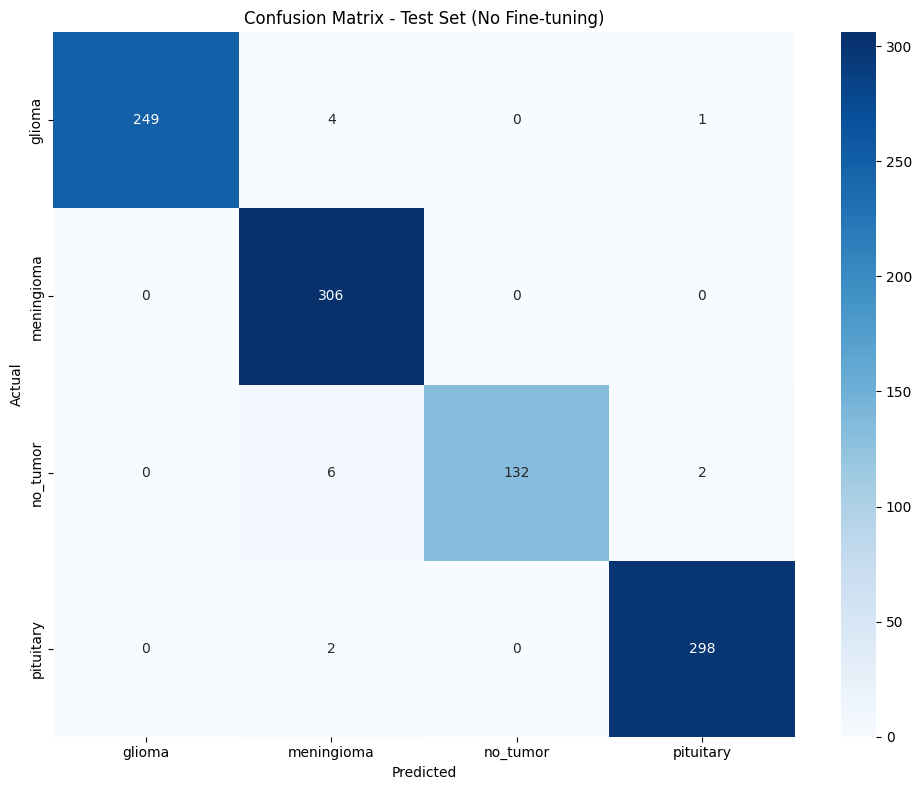

In [13]:
# 4.4 Confusion Matrix - Test Set
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - Test Set (No Fine-tuning)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('brisc2025_test_cm.png', dpi=150)
plt.show()

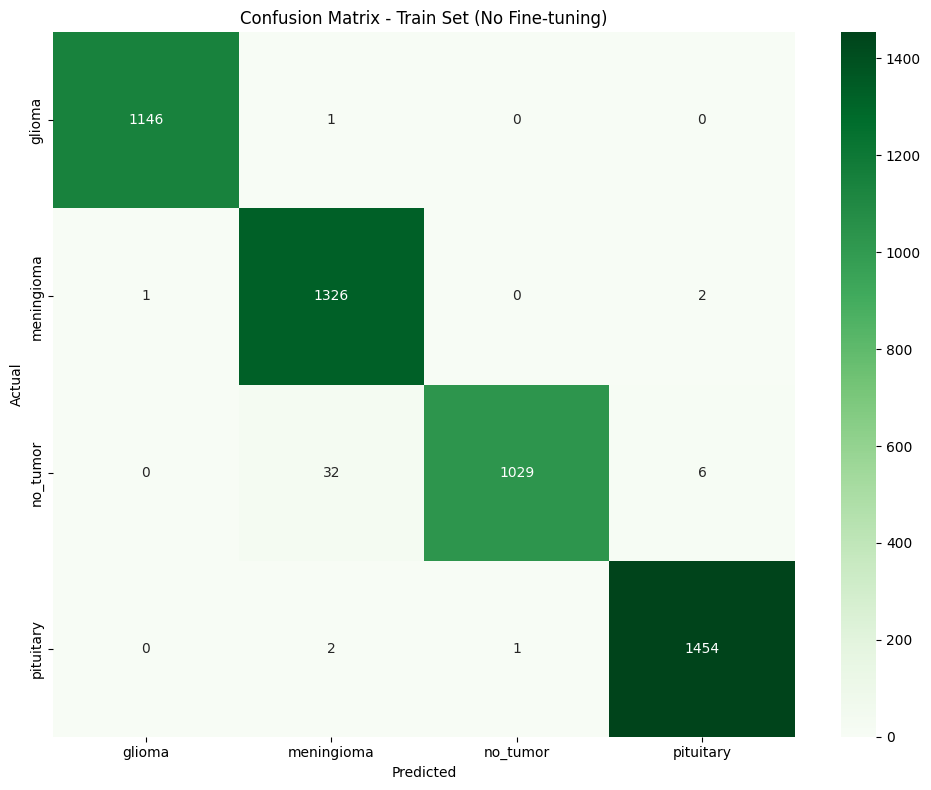

In [14]:
# 4.5 Confusion Matrix - Train Set
cm_train = confusion_matrix(y_true_train, y_pred_train)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - Train Set (No Fine-tuning)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('brisc2025_train_cm.png', dpi=150)
plt.show()

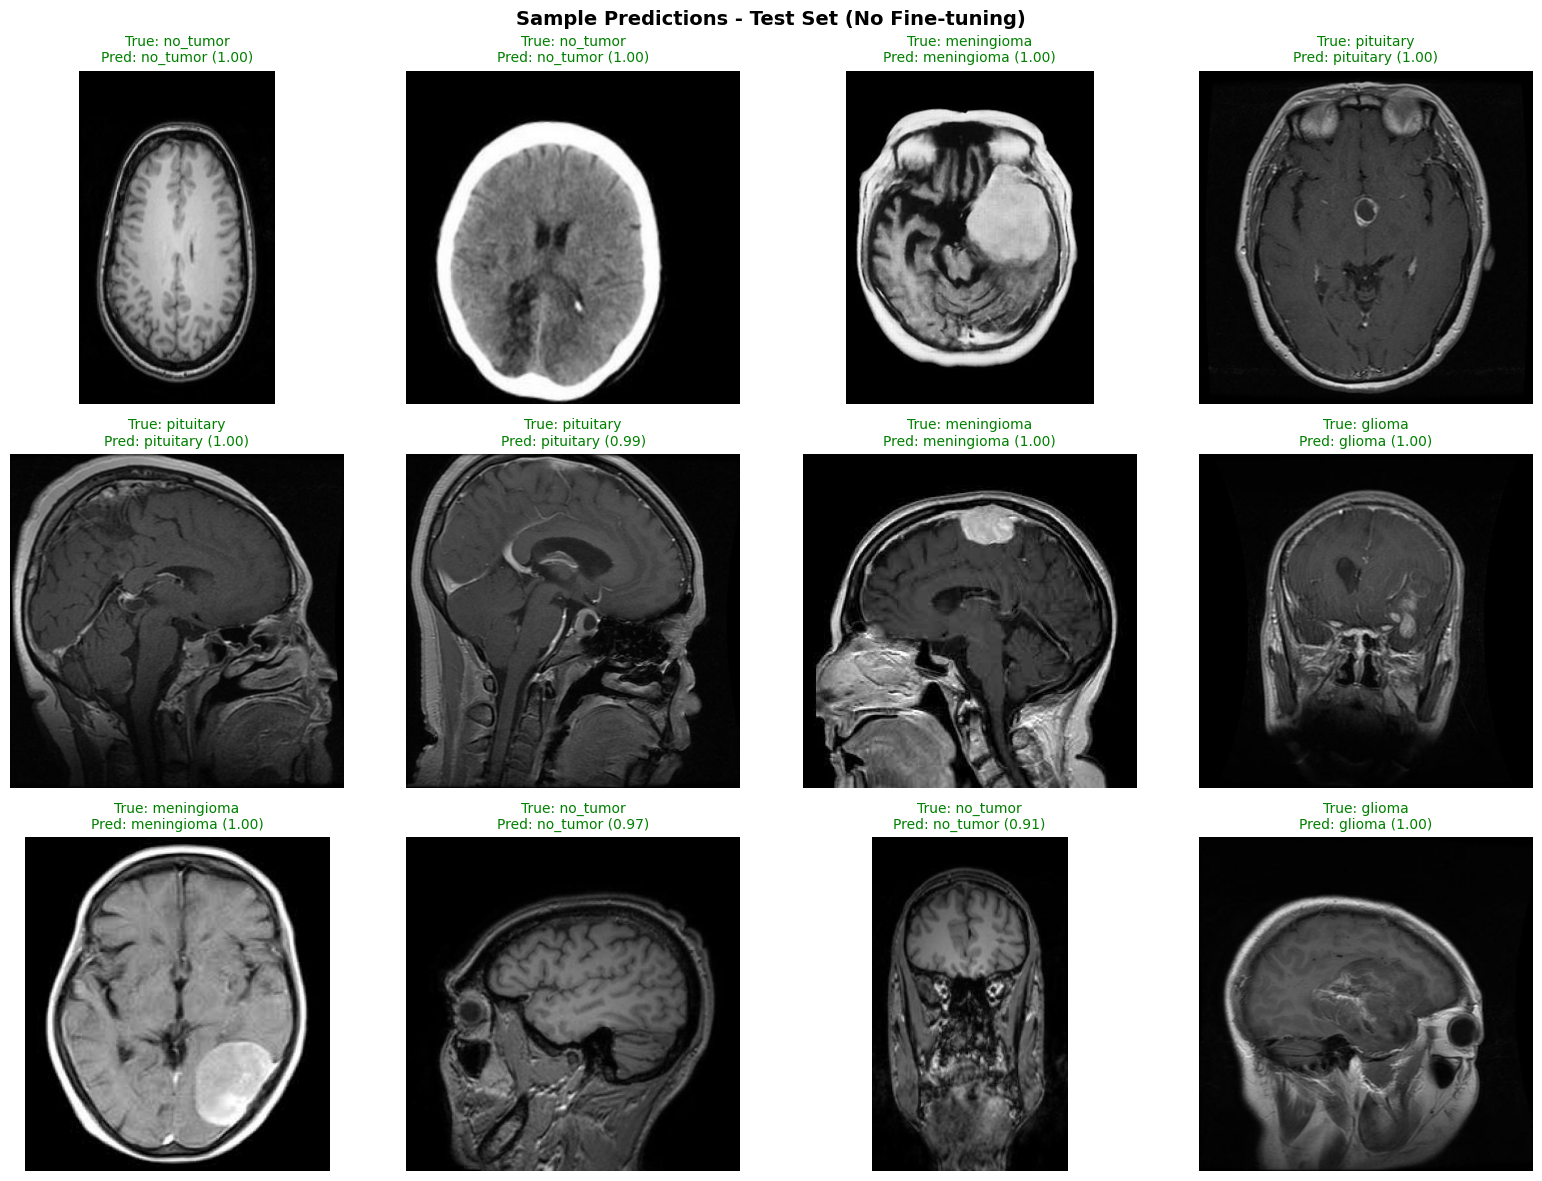

In [15]:
# 4.6 Sample Predictions Visualization (Test Set)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_indices = np.random.choice(len(test_df), size=12, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    row_idx = idx // 4
    col_idx = idx % 4
    
    # Load and preprocess image
    img_path = test_df.iloc[sample_idx]['filepath']
    true_label = test_df.iloc[sample_idx]['label']
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()
    
    img_resized = resize_with_padding(img, IMG_SIZE)
    img_preprocessed = preprocess_image(img_resized)
    
    # Predict
    pred = model.predict(np.expand_dims(img_preprocessed, axis=0), verbose=0)
    pred_label = CLASSES[np.argmax(pred)]
    confidence = np.max(pred)
    
    # Display
    axes[row_idx, col_idx].imshow(img_display)
    color = 'green' if pred_label == true_label else 'red'
    axes[row_idx, col_idx].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", 
                                      color=color, fontsize=10)
    axes[row_idx, col_idx].axis('off')

plt.suptitle('Sample Predictions - Test Set (No Fine-tuning)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('brisc2025_sample_predictions_test_no_finetune.png', dpi=150)
plt.show()

In [16]:


# Duong dan model ResNet50
RESNET50_MODEL_PATH = 'model/model_phamthanhdoanh.keras'

# Hyperparameters cho ResNet50
IMG_SIZE_RESNET = (224, 224)
BATCH_SIZE = 32

CLASSES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
NUM_CLASSES = len(CLASSES)

print(f'ResNet50 Model Path: {RESNET50_MODEL_PATH}')
print(f'Image Size: {IMG_SIZE_RESNET}')

ResNet50 Model Path: model/model_phamthanhdoanh.keras
Image Size: (224, 224)


In [17]:
# --- Cac ham ho tro cho ResNet50 ---

def resize_with_padding_resnet(image, target_size=(224, 224)):
    """Resize anh ma KHONG bi meo (them vien den)"""
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(image, (new_w, new_h))
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def preprocess_image_resnet(image):
    """CLAHE enhancement + ResNet50 ImageNet preprocessing"""
    # 1. CLAHE enhancement (tot cho MRI)
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    
    # 2. ResNet50 ImageNet preprocessing
    enhanced = enhanced.astype(np.float32)
    # Convert RGB to BGR
    enhanced = enhanced[..., ::-1]
    # Zero-center by ImageNet mean (BGR order)
    enhanced[..., 0] -= 103.939  # Blue
    enhanced[..., 1] -= 116.779  # Green  
    enhanced[..., 2] -= 123.68   # Red
    
    return enhanced

class ResNetDataGenerator(tf.keras.utils.Sequence):
    """Generator rieng cho ResNet50"""
    def __init__(self, dataframe, batch_size=32, img_size=(224, 224), 
                 shuffle=False, class_names=None):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.class_names = class_names or sorted(dataframe['label'].unique())
        self.n_classes = len(self.class_names)
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[batch_indexes]
        X = np.zeros((len(batch_data), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), self.n_classes), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            # 1. Load anh
            img = cv2.imread(row['filepath'])
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # 2. Resize giu ty le
                img = resize_with_padding_resnet(img, self.img_size)
                # 3. CLAHE + ResNet50 preprocessing
                X[i] = preprocess_image_resnet(img)
                # 4. One-hot label
                label_idx = self.class_names.index(row['label'])
                y[i, label_idx] = 1.0
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Tao DataFrame cho ResNet50
def create_dataframe_resnet(base_dir, classes):
    data = []
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        if os.path.exists(cls_dir):
            for img_name in os.listdir(cls_dir):
                if img_name.endswith(('.jpg', '.png', '.jpeg')):
                    data.append({
                        'filepath': os.path.join(cls_dir, img_name),
                        'label': cls
                    })
    return pd.DataFrame(data)

# Tao DataFrame
train_df_resnet = create_dataframe_resnet(TRAIN_DIR, CLASSES)
test_df_resnet = create_dataframe_resnet(TEST_DIR, CLASSES)

print(f'Train samples: {len(train_df_resnet)}')
print(f'Test samples: {len(test_df_resnet)}')

Train samples: 5000
Test samples: 1000


In [18]:
# --- Danh gia ResNet50 ---
print('\n' + '='*50)
print('RESNET50 EVALUATION ON BRISC2025')
print('='*50)

# Tao Generator cho Test set
test_gen_resnet = ResNetDataGenerator(
    test_df_resnet, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE_RESNET,
    shuffle=False, 
    class_names=CLASSES
)

# Tao Generator cho Train set
train_gen_resnet = ResNetDataGenerator(
    train_df_resnet, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE_RESNET,
    shuffle=False, 
    class_names=CLASSES
)

print(f'ResNet50 Test batches: {len(test_gen_resnet)}')
print(f'ResNet50 Train batches: {len(train_gen_resnet)}')

# Load Model
if os.path.exists(RESNET50_MODEL_PATH):
    print('\nLoading pretrained ResNet50 model...')
    resnet_model = keras.models.load_model(RESNET50_MODEL_PATH)
    print(f'Successfully loaded model from {RESNET50_MODEL_PATH}')
    resnet_model.summary()
else:
    print(f'Error: Model file not found at {RESNET50_MODEL_PATH}')


RESNET50 EVALUATION ON BRISC2025
ResNet50 Test batches: 32
ResNet50 Train batches: 157

Loading pretrained ResNet50 model...
Successfully loaded model from model/model_phamthanhdoanh.keras


Model: "ResNet50_BrainTumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,083,854 (137.65 MB)

 Trainable params: 5,652,228 (21.56 MB)

 Non-trainable params: 19,127,168 (72.96 MB)

 Optimizer params: 11,304,458 (43.12 MB)

In [19]:
# 5.1 Danh gia ResNet50 tren Test Set
print('Danh gia ResNet50 tren Test Set (No Fine-tuning)...')

resnet_test_preds = []
resnet_test_labels = []

for i in tqdm(range(len(test_gen_resnet)), desc='Evaluating Test Set'):
    X_batch, y_batch = test_gen_resnet[i]
    preds = resnet_model.predict(X_batch, verbose=0)
    resnet_test_preds.extend(np.argmax(preds, axis=1))
    resnet_test_labels.extend(np.argmax(y_batch, axis=1))

y_pred_resnet_test = np.array(resnet_test_preds)
y_true_resnet_test = np.array(resnet_test_labels)

print('\nClassification Report - ResNet50 (Test Set):')
print(classification_report(y_true_resnet_test, y_pred_resnet_test, target_names=CLASSES))

accuracy_resnet_test = np.mean(y_pred_resnet_test == y_true_resnet_test)
print(f'\nResNet50 Test Accuracy (No Fine-tuning): {accuracy_resnet_test:.4f}')

Danh gia ResNet50 tren Test Set (No Fine-tuning)...


Evaluating Test Set: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


Classification Report - ResNet50 (Test Set):
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       254
  meningioma       0.95      0.99      0.97       306
    no_tumor       1.00      0.96      0.98       140
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


ResNet50 Test Accuracy (No Fine-tuning): 0.9810


Kết quả model resnet đạt dc khi test trên tập test brisc2025 là 0.9810 kah1 cao chứng tỏ mô hình khá tốt

In [20]:
# 5.2 Danh gia ResNet50 tren Train Set
print('Danh gia ResNet50 tren Train Set (No Fine-tuning)...')

resnet_train_preds = []
resnet_train_labels = []

for i in tqdm(range(len(train_gen_resnet)), desc='Evaluating Train Set'):
    X_batch, y_batch = train_gen_resnet[i]
    preds = resnet_model.predict(X_batch, verbose=0)
    resnet_train_preds.extend(np.argmax(preds, axis=1))
    resnet_train_labels.extend(np.argmax(y_batch, axis=1))

y_pred_resnet_train = np.array(resnet_train_preds)
y_true_resnet_train = np.array(resnet_train_labels)

print('\nClassification Report - ResNet50 (Train Set):')
print(classification_report(y_true_resnet_train, y_pred_resnet_train, target_names=CLASSES))

accuracy_resnet_train = np.mean(y_pred_resnet_train == y_true_resnet_train)
print(f'\nResNet50 Train Accuracy (No Fine-tuning): {accuracy_resnet_train:.4f}')

Danh gia ResNet50 tren Train Set (No Fine-tuning)...


Evaluating Train Set: 100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


Classification Report - ResNet50 (Train Set):
              precision    recall  f1-score   support

      glioma       0.99      1.00      0.99      1147
  meningioma       0.97      0.99      0.98      1329
    no_tumor       1.00      0.95      0.97      1067
   pituitary       1.00      1.00      1.00      1457

    accuracy                           0.99      5000
   macro avg       0.99      0.98      0.99      5000
weighted avg       0.99      0.99      0.99      5000


ResNet50 Train Accuracy (No Fine-tuning): 0.9862


Kết quả train là 0.9862

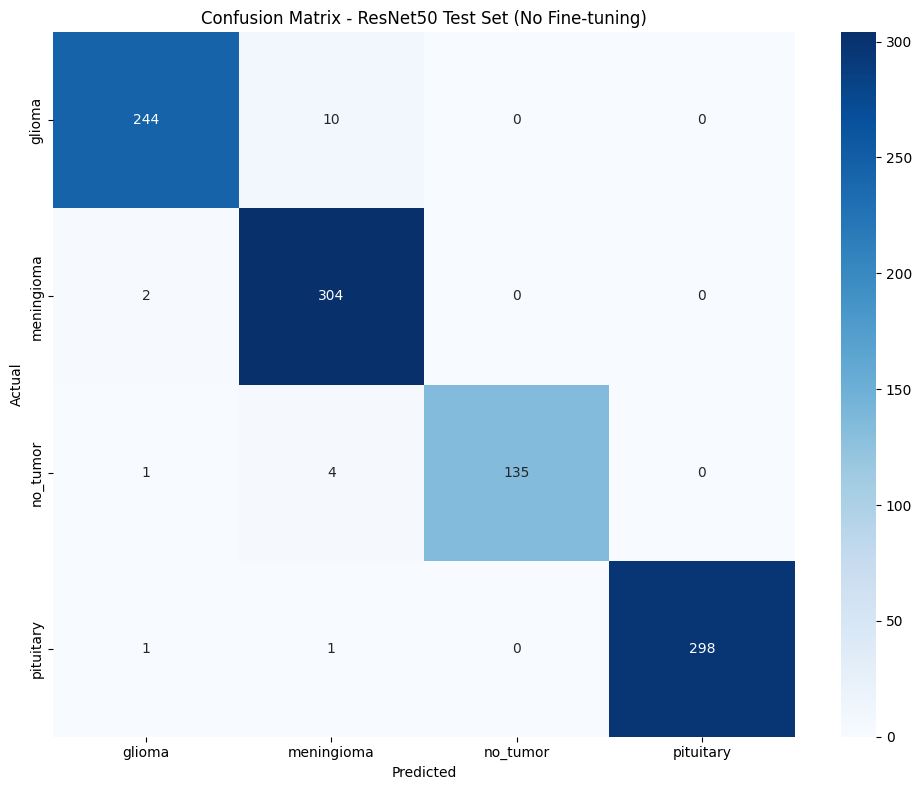

In [21]:
# 5.3 Confusion Matrix - ResNet50 Test Set
cm_resnet_test = confusion_matrix(y_true_resnet_test, y_pred_resnet_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - ResNet50 Test Set (No Fine-tuning)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('brisc2025_resnet50_test_cm.png', dpi=150)
plt.show()

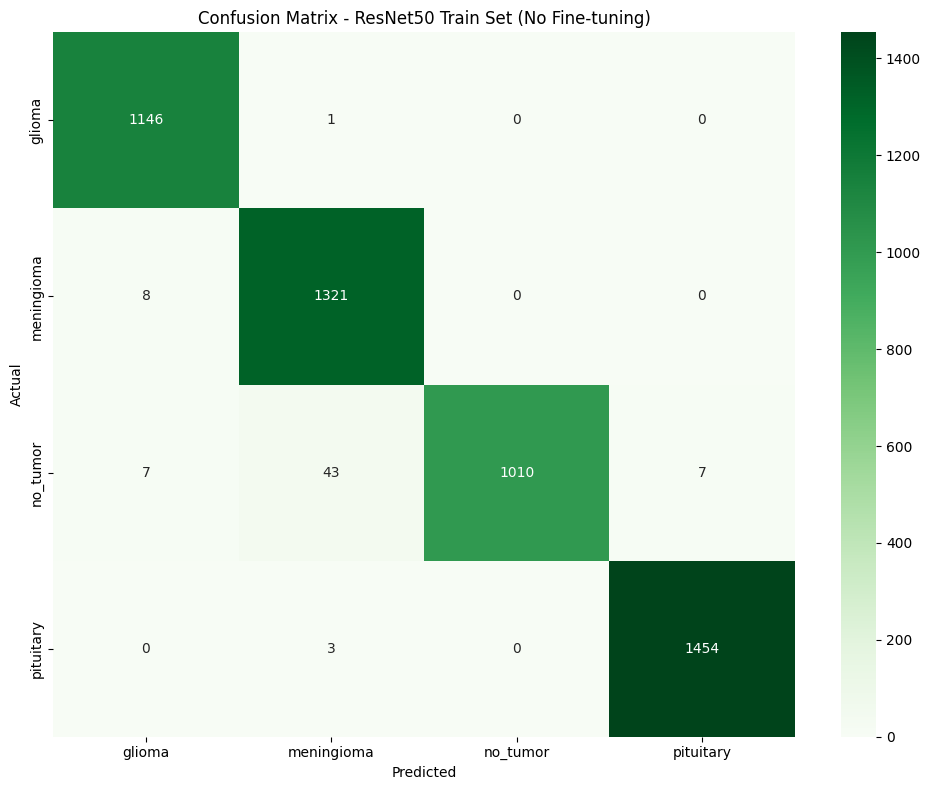

In [22]:
# 5.4 Confusion Matrix - ResNet50 Train Set
cm_resnet_train = confusion_matrix(y_true_resnet_train, y_pred_resnet_train)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet_train, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - ResNet50 Train Set (No Fine-tuning)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('brisc2025_resnet50_train_cm.png', dpi=150)
plt.show()

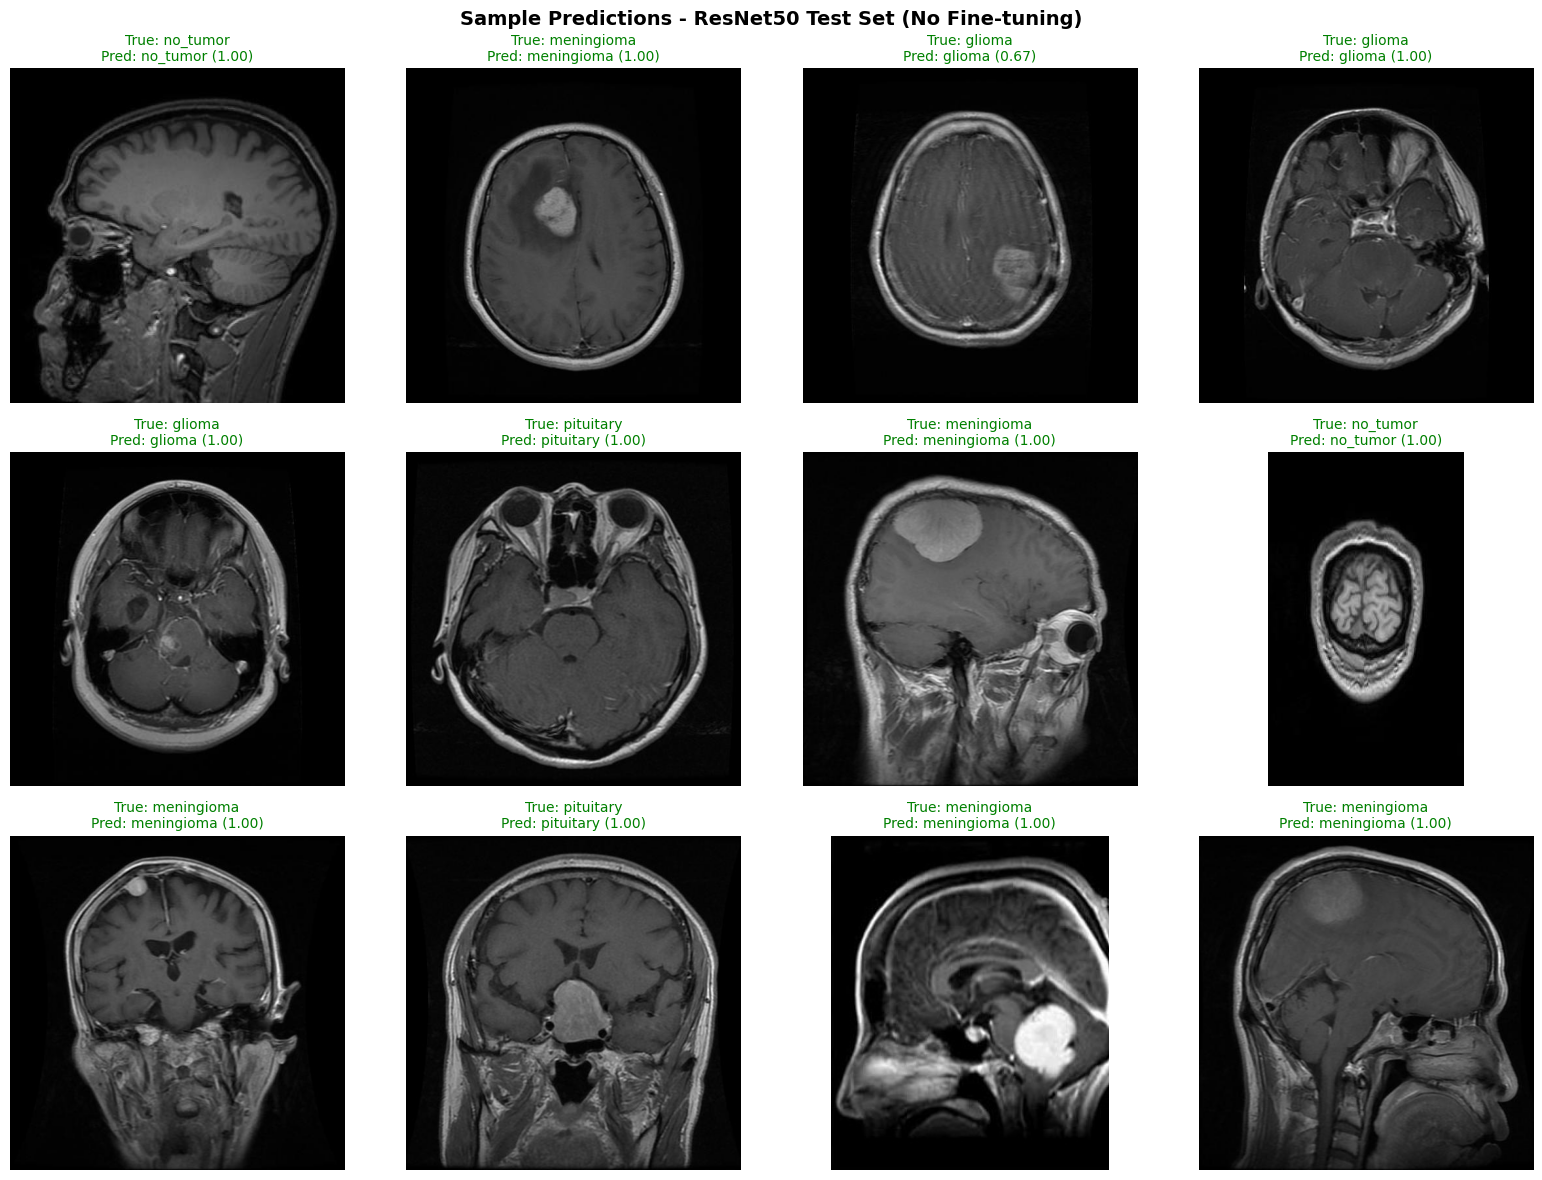

In [23]:
# 5.5 Sample Predictions - ResNet50
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_indices = np.random.choice(len(test_df_resnet), size=12, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    row_idx = idx // 4
    col_idx = idx % 4
    
    # Load and preprocess image
    img_path = test_df_resnet.iloc[sample_idx]['filepath']
    true_label = test_df_resnet.iloc[sample_idx]['label']
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()
    
    img_resized = resize_with_padding_resnet(img, IMG_SIZE_RESNET)
    img_preprocessed = preprocess_image_resnet(img_resized)
    
    # Predict
    pred = resnet_model.predict(np.expand_dims(img_preprocessed, axis=0), verbose=0)
    pred_label = CLASSES[np.argmax(pred)]
    confidence = np.max(pred)
    
    # Display
    axes[row_idx, col_idx].imshow(img_display)
    color = 'green' if pred_label == true_label else 'red'
    axes[row_idx, col_idx].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})', 
                                      color=color, fontsize=10)
    axes[row_idx, col_idx].axis('off')

plt.suptitle('Sample Predictions - ResNet50 Test Set (No Fine-tuning)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('brisc2025_resnet50_sample_predictions.png', dpi=150)
plt.show()

In [24]:
# 5.6 So sanh ket qua Xception vs ResNet50
print('\n' + '='*50)
print('SO SANH KET QUA: XCEPTION vs RESNET50')
print('='*50)
print(f'\nXception Test Accuracy:  {accuracy_test:.4f}')
print(f'ResNet50 Test Accuracy:  {accuracy_resnet_test:.4f}')
print(f'\nXception Train Accuracy: {accuracy_train:.4f}')
print(f'ResNet50 Train Accuracy: {accuracy_resnet_train:.4f}')


SO SANH KET QUA: XCEPTION vs RESNET50

Xception Test Accuracy:  0.9850
ResNet50 Test Accuracy:  0.9810

Xception Train Accuracy: 0.9910
ResNet50 Train Accuracy: 0.9862


Kết quả model hiện có hoạt động rất tốt trên dataset brics2025